In [16]:
import matplotlib.pylab as plt
import numpy as np
from scipy.optimize import curve_fit 
import glob
import os

import matplotlib.ticker as ticker

plt.style.use(['fast', 'science'])

%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 200
glob.glob('logging/*')


['logging/MokuDataLoggerData_20230223_150002.li',
 'logging/calibration.li',
 'logging/spitfire_analysis.ipynb',
 'logging/spitfire_osc_first',
 'logging/converted_1_30pm',
 'logging/1_39',
 'logging/moku_go_data_analysis.ipynb',
 'logging/debug.log',
 'logging/MokuDataLoggerData_20230223_150002.csv',
 'logging/feb_14',
 'logging/spitfire_osc_wide_window']

In [17]:
def model(x, a, x0, s, C):
    return a/np.sqrt(2*np.pi)/s*np.exp(-1/2*(x-x0)**2/s**2) + C

In [18]:
# uncalibrated files
files = sorted(glob.glob('logging/1_39/[0-9]*.csv'))[25:-25]

pos_mm = np.array([float(".".join(os.path.basename(f).split('_')[:2])) for f in files])
e_pos = 100e-6
V = np.array([np.genfromtxt(f, skip_header= 8, dtype = float, 
                        delimiter = ',').mean(axis = 0)[-1] for f in files])

e_V = np.array([np.genfromtxt(f, skip_header= 8, dtype = float, 
                        delimiter = ',').std(axis = 0)[-1] for f in files])

zipped = zip(pos_mm, V, e_V)
pos_mm, V, e_V = zip(*sorted(zipped))
pos_mm = np.array(pos_mm)
V = np.array(V)
e_V = np.array(e_V)

In [19]:
# plt.errorbar(pos_mm, V, xerr = e_pos, yerr= e_V ,fmt = 'ko', ms = .1)
xx = np.linspace(np.min(pos_mm), np.max(pos_mm), 200)
# plt.plot(xx, model(xx, .05, 22.659,.008, .5))

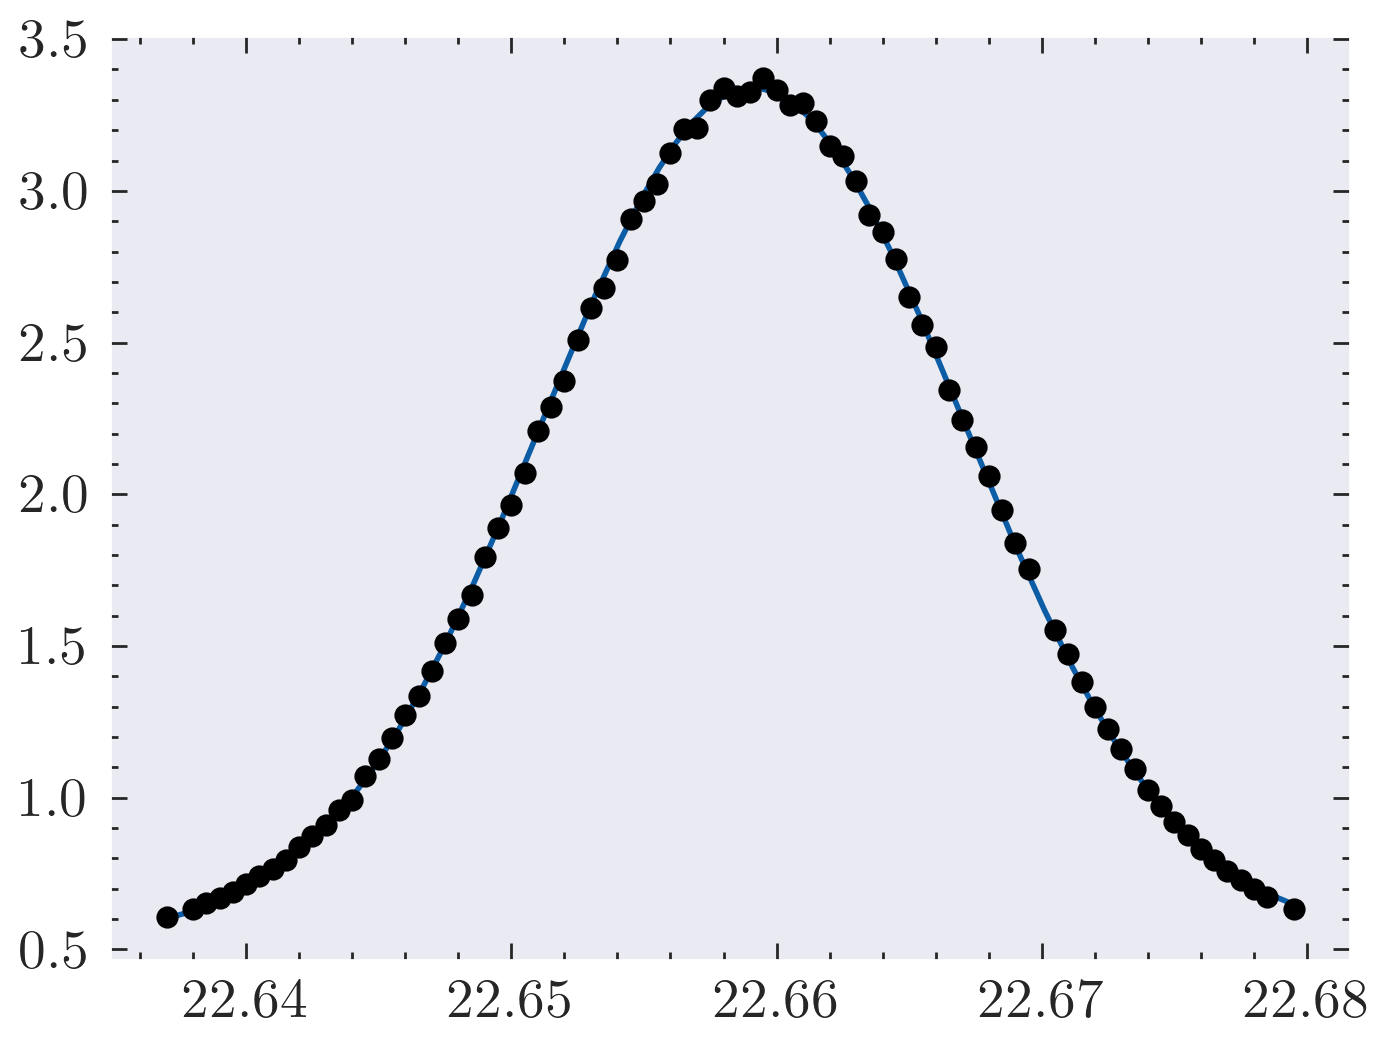

In [20]:
fit, err = curve_fit(model, pos_mm, V, sigma = e_V, absolute_sigma= True,  p0 = [.05, 22.659,.008, .5])
plt.plot(xx, model(xx, *fit))
plt.plot(pos_mm, V,'k.')
# plt.text(f'{fit}')

**We measured in delay distance. The time delay is distance change times two. But the signal is twice as wide, in time domain, as the original signal by symmetry!!**

In [21]:
width = fit[-2]/1e3/3e8 /1e-15 * 2
e_width = np.sqrt(np.diag(err))[-2]/1e3/3e8 /1e-15
print(f'{width:.3f} +/- {e_width:.3f}')

52.983 +/- 0.011


In [22]:
t_fs = (pos_mm - fit[-3])/1e3/2.998e8/1e-15*2
e_t_fs = np.sqrt((e_pos/1e3/2.998e8/1e-15*2)**2 + (np.sqrt(np.diag(err))[-3]/1e3/2.998e8/1e-15*2)**2)

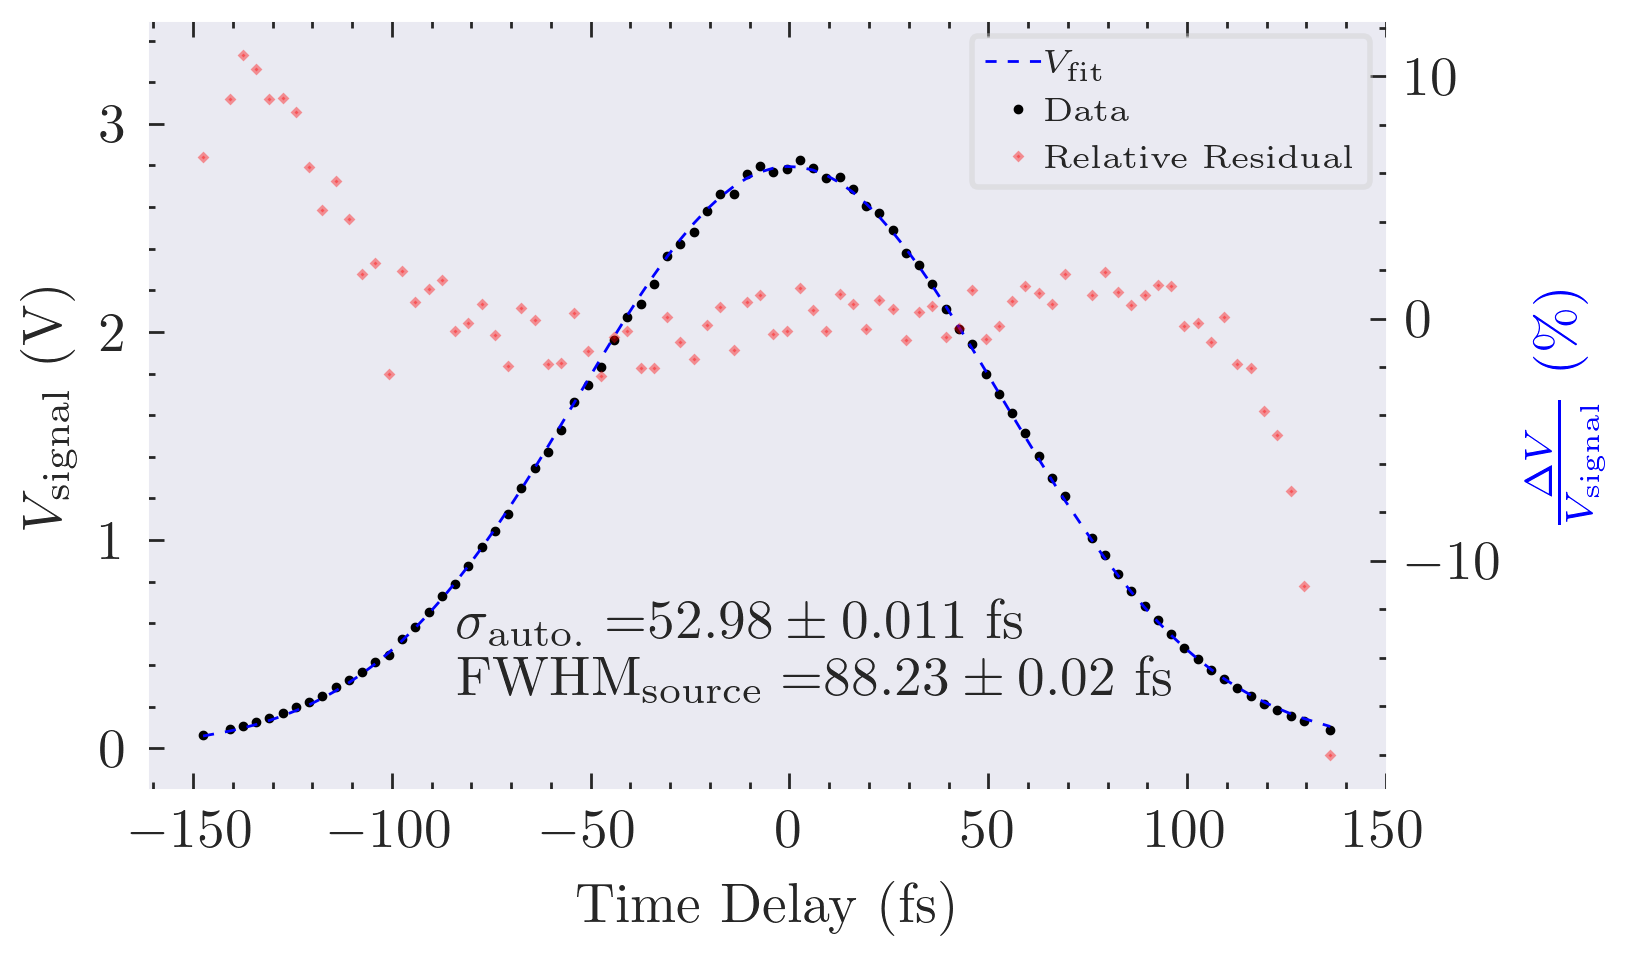

In [23]:
signal = model(pos_mm, *fit[:-1], 0)

fig = plt.figure(figsize = (4,2.5))

ax1 = plt.gca()

line_1 = ax1.plot(t_fs, signal, 'b-', lw = .5, dashes = (4,4), zorder = 1, label ='$V_{\mathrm{fit}}$ ')

line_2 = ax1.plot(t_fs, V-fit[-1], 'k.', ms = 1.5, zorder = 0, label ='Data')


ax1.set_ylabel('$V_{\mathrm{signal}}$ (V)')
ax1.set_ylim(-.2,3.5)

ax2 = ax1.twinx()
line_3 = ax2.plot(t_fs, (V - model(pos_mm, *fit)) / (V- fit[-1]) *100,'rD', label = 'Relative Residual',
                 zorder = -2, ms = .5, alpha = .4)

ax2.set_ylabel(r'$\frac{\Delta V}{V_{\mathrm{signal}}}$ (\%)', color = 'b')
# ax2.set_yscale('log')


lines = [line_1[0],line_2[0],line_3[0]]
labs = [l.get_label() for l in lines]

fwhm_factor = 2.355

ax1.set_xlabel('Time Delay (fs)')
text_out = "$\sigma_{\mathrm{auto.}}=$" + f"${width:.2f}\pm{e_width:.3f}$ fs\n"+\
"$\mathrm{FWHM}_{\mathrm{source}}=$" + f"${width/np.sqrt(2) * fwhm_factor:.2f}\pm{e_width/np.sqrt(2) *fwhm_factor:.2f}$ fs\n"

ax1.text(.25,.05, s = text_out, transform = ax1.transAxes)
leg = plt.legend(lines, labs, loc= 1, framealpha = .4, shadow =False, frameon = 1,
                 handletextpad=-.2, prop={'size': 6} )
frame = leg.get_frame()
# frame.set_color('white')
plt.savefig('figures/menlo_signal.pdf', bbox_inches = 'tight', format = 'pdf')


We see this asymmetry due to imperfect alignment. But this is good enough?

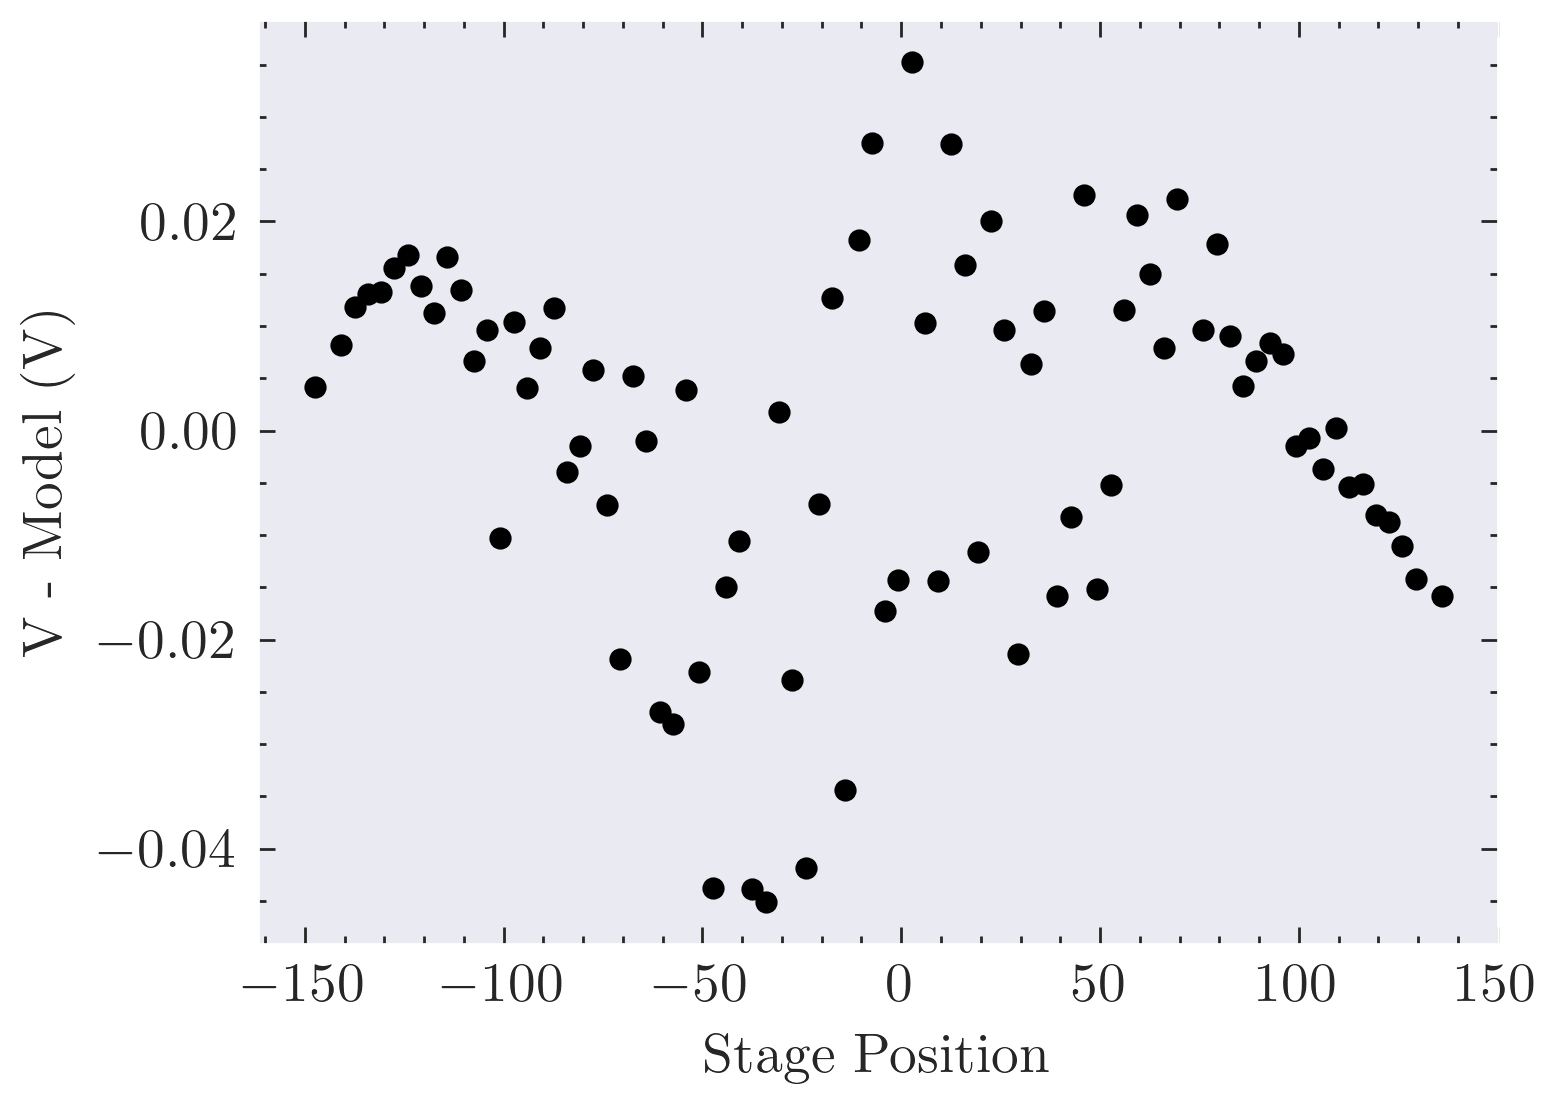

In [24]:
# plt.plot(xx, model(xx, *fit))
# plt.plot(pos_mm, V,'ko', ms = 1.5)
plt.plot(t_fs, V - model(pos_mm, *fit), 'k.')
plt.ylabel('V - Model (V)')
plt.xlabel('Stage Position')
plt.savefig("figures/feb_13_1_39_Res.pdf", dpi =300, bbox_inches = 'tight')

In [25]:
V[np.argmin(np.abs(pos_mm-22.652))]

2.3734061255012224

In [26]:
pos_mm[np.argmin(np.abs(pos_mm-22.652))]

22.652

In [27]:
idx_err = [i for i, f in sorted(zip(np.arange(len(files)), e_V), key=lambda pair: pair[1], reverse = True)]

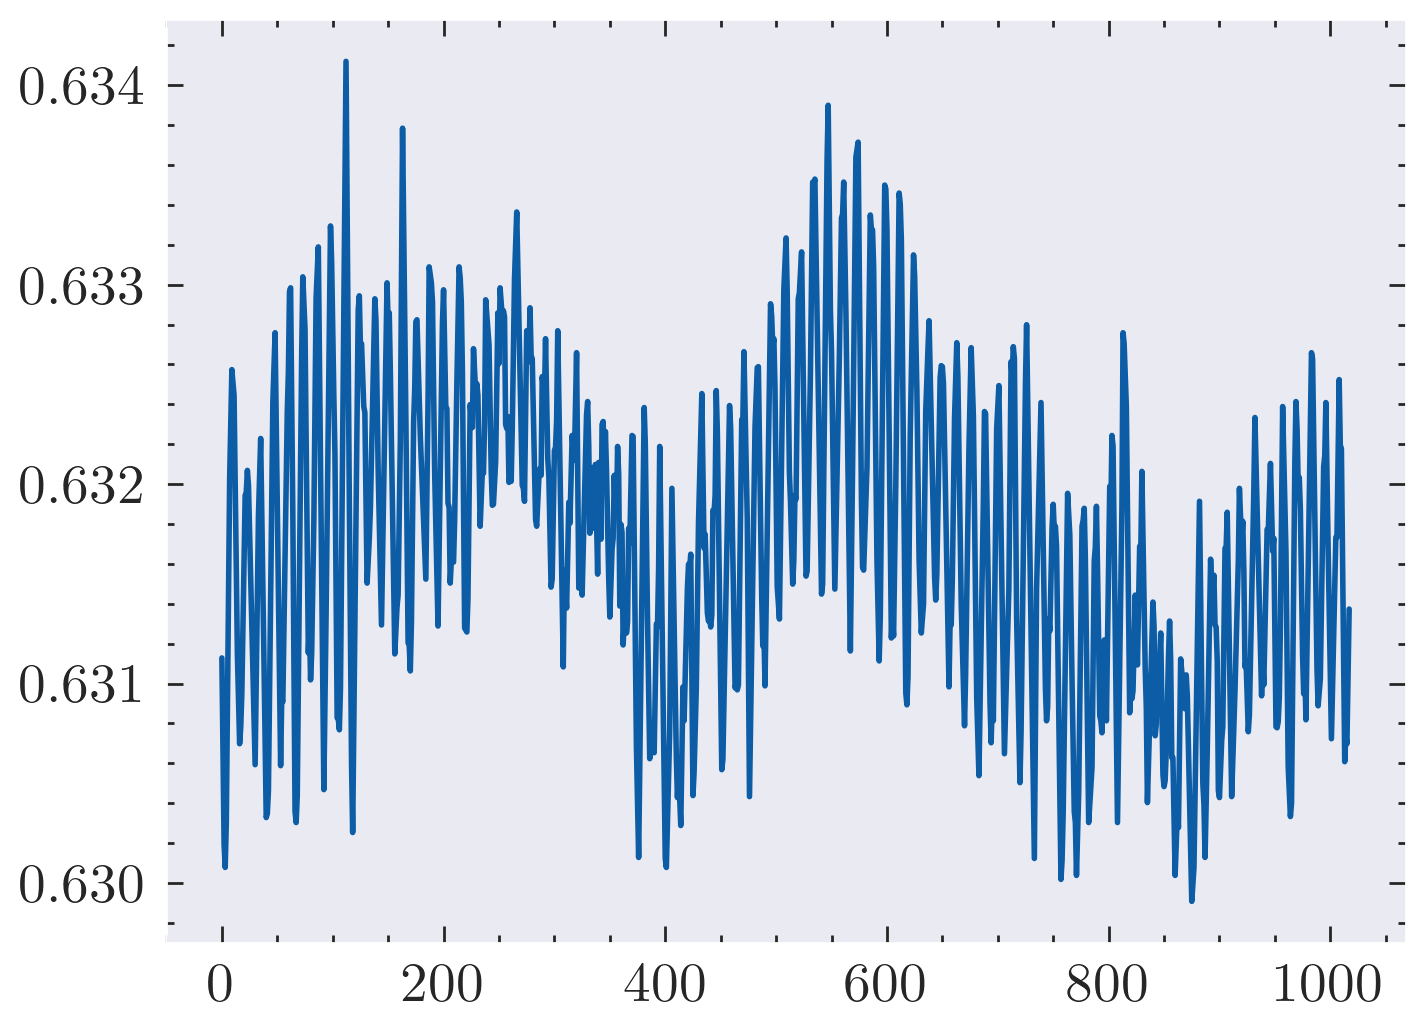

In [28]:
plt.plot(np.genfromtxt(files[idx_err[-2]], skip_header= 8, dtype = float, 
                        delimiter = ',')[:,-1])

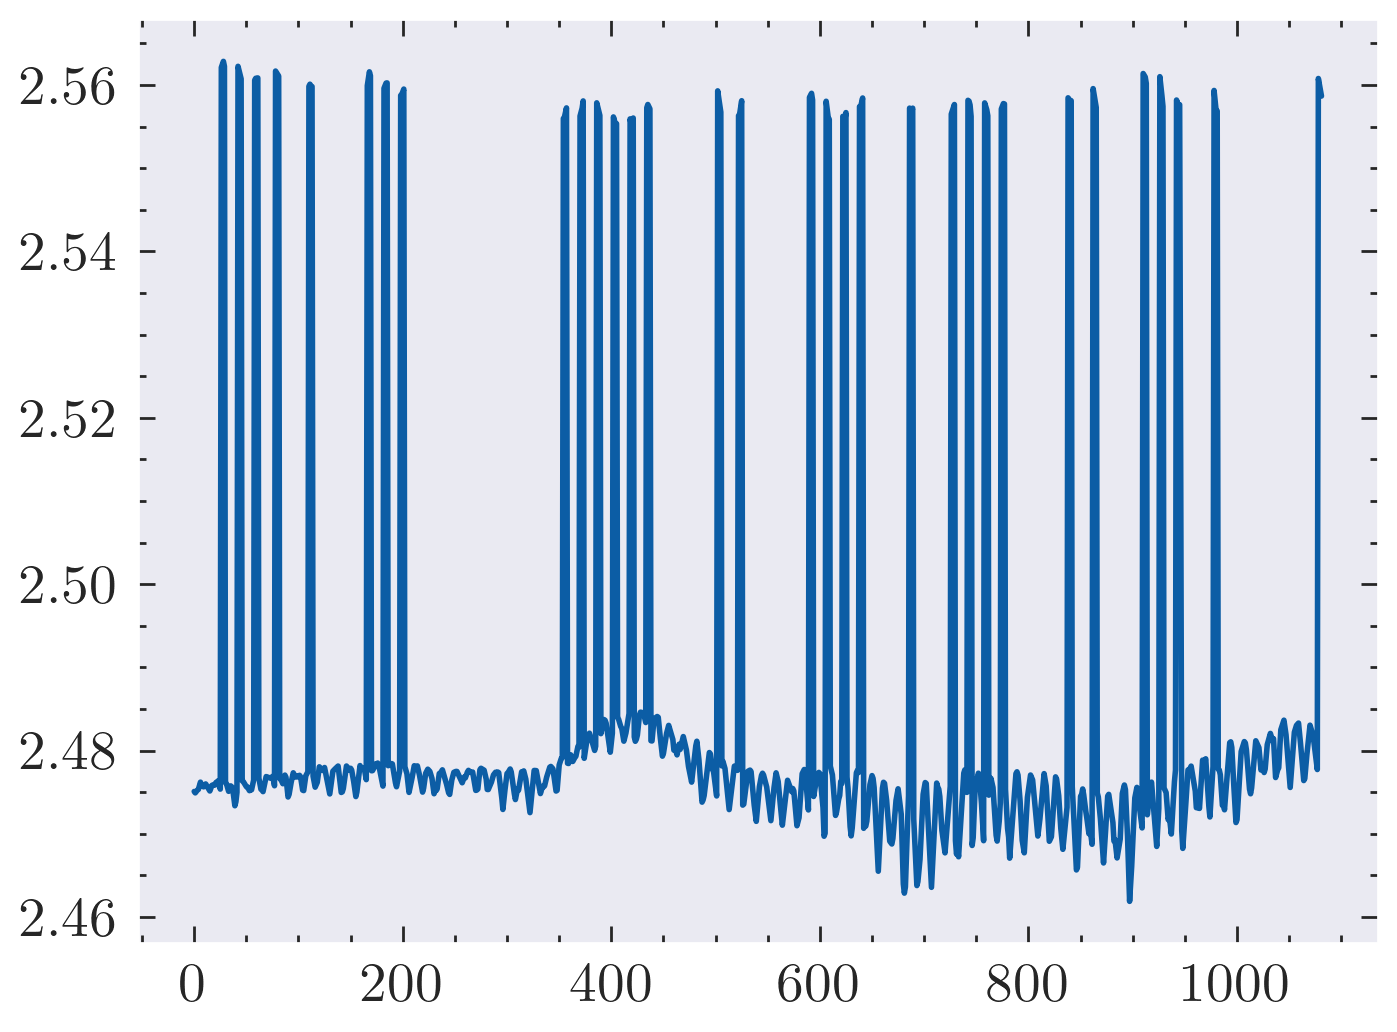

In [29]:
plt.plot(np.genfromtxt(files[idx_err[2]], skip_header= 8, dtype = float, 
                        delimiter = ',')[:,-1])

In [30]:
plt.plot(np.sum(np.abs([np.fft.rfft(np.genfromtxt(f, skip_header= 8, dtype = float, 
                        delimiter = ',')[:,-1]) for f in files]), axis = 0))
plt.yscale('log')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (83,) + inhomogeneous part.

In [ ]:

mask = np.cos(np.linspace(-np.pi/2,np.pi/2, 1000))

In [ ]:
fft = np.fft.rfft(np.genfromtxt(files[idx_err[10]], skip_header= 8, dtype = float, 
                        delimiter = ',')[:,-1][:1000]*mask)


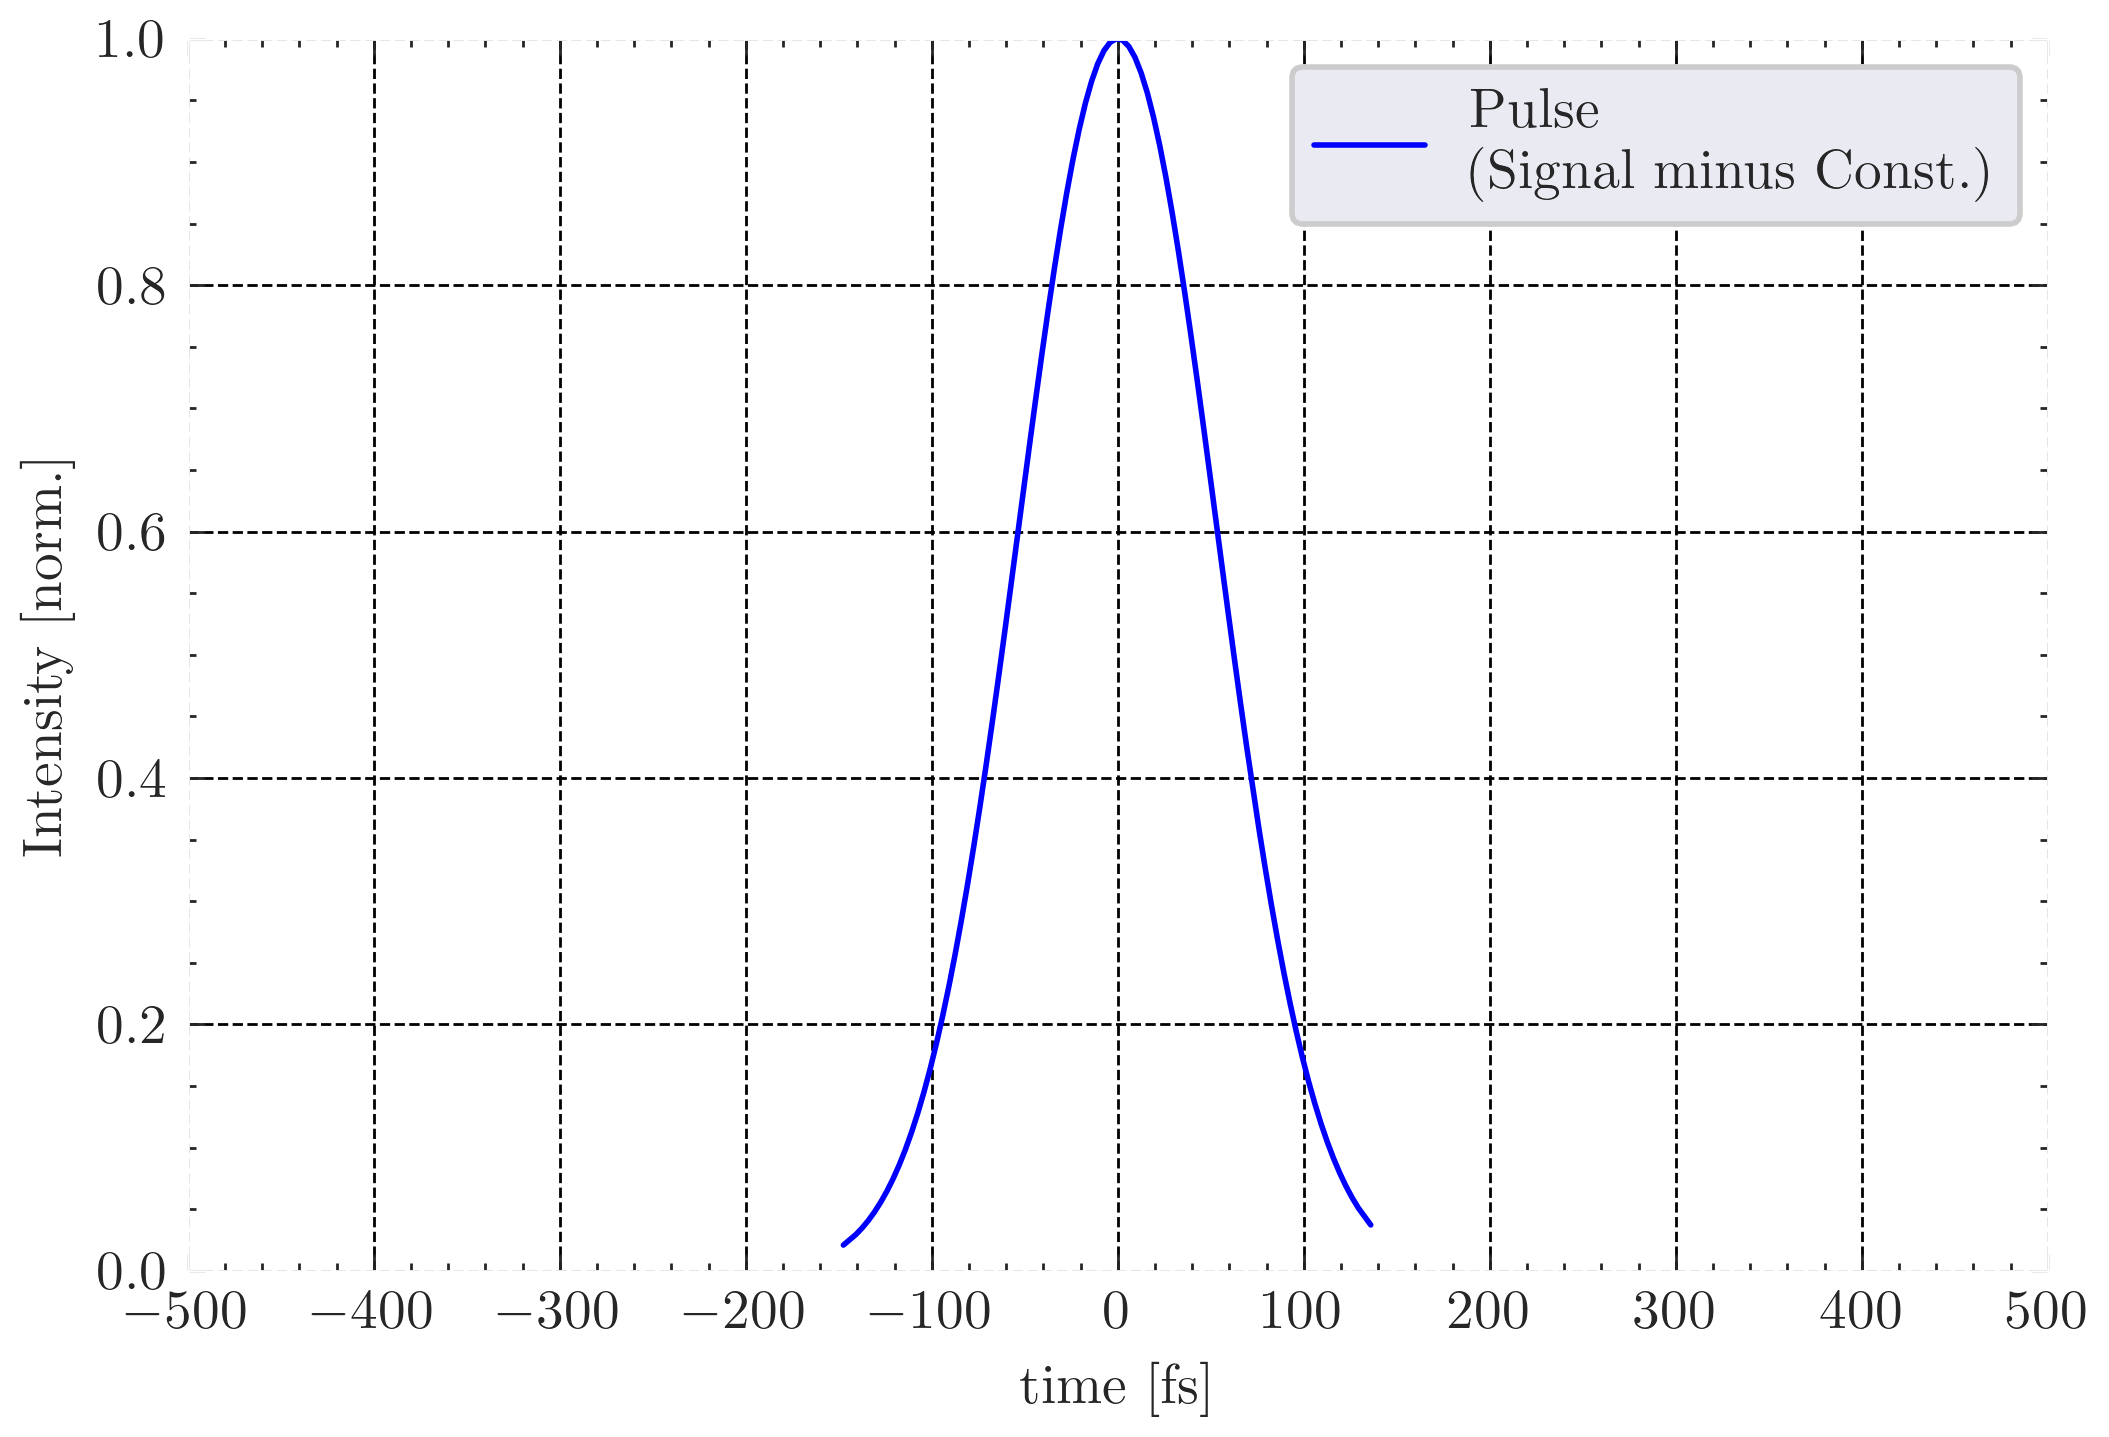

In [48]:
fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot()
ax.set_facecolor('xkcd:white')

ax.plot(t_fs, signal/np.max(signal), 'b-', ms = 2, label = 'Pulse\n(Signal minus Const.)')
ax.set_xlim(-500,500)
ax.set_ylim(0,1)
ax.grid(ls = '--',c='k')
ax.set_ylabel('Intensity [norm.]')
ax.set_xlabel('time [fs]')
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(-500,600,100)))
ax.legend(loc= 1, framealpha = 1, shadow =False, frameon = 1)

fig.savefig('figures/menlo_trace.pdf', format= 'pdf', bbox_inches = 'tight')